# Evaluating an SSH Mapping algorithm using OceanBench and 4dvarnet-starter

## Overview
In this notebook we show how to:
- install necessary package
- download necessary data from the data-registry using dvc
- use oceanbench to format and create pytorch dataloading utils
- use 4dvarnet-starter to instantiate a training pipeline
- use oceanbench to visualize the results and compute metrics
- orchestrate all of this using hydra

## Setup

### Download source from github
 - **oceanbench-data-registry**: data-registry for versioning and accessing your ocean datasets everywhere
 - **4dvarnet-starter**: implementation of the 4dvarnet algorithm using pytorch lightning
 - **oceanbench**: all necessary tools to setup and evaluate a machine learning pipeline using ocean data

In [ ]:
!git clone https://github.com/CIA-Oceanix/4dvarnet-starter.git
!git clone https://github.com/quentinf00/oceanbench-data-registry.git
!git clone https://github.com/jejjohnson/oceanbench.git


Cloning into '4dvarnet-starter'...
remote: Enumerating objects: 3465, done.
remote: Counting objects: 100% (330/330), done.
remote: Compressing objects: 100% (216/216), done.
remote: Total 3465 (delta 202), reused 147 (delta 114), pack-reused 3135
Receiving objects: 100% (3465/3465), 366.72 KiB | 5.09 MiB/s, done.
Resolving deltas: 100% (2630/2630), done.
Cloning into 'oceanbench-data-registry'...
remote: Enumerating objects: 109, done.
remote: Counting objects: 100% (109/109), done.
remote: Compressing objects: 100% (75/75), done.
remote: Total 109 (delta 28), reused 99 (delta 23), pack-reused 0
Receiving objects: 100% (109/109), 13.45 KiB | 13.45 MiB/s, done.
Resolving deltas: 100% (28/28), done.
Cloning into 'oceanbench'...
remote: Enumerating objects: 2367, done.
remote: Counting objects: 100% (845/845), done.
remote: Compressing objects: 100% (392/392), done.
remote: Total 2367 (delta 468), reused 738 (delta 424), pack-reused 1522
Receiving objects: 100% (2367/2367), 45.13 MiB | 1

In [ ]:
%cd 4dvarnet-starter
!git pull --tags
!git checkout patch200
%cd ..

/content/4dvarnet-starter
remote: Enumerating objects: 60, done.
remote: Counting objects: 100% (32/32), done.
remote: Compressing objects: 100% (18/18), done.
remote: Total 60 (delta 14), reused 27 (delta 13), pack-reused 28
Unpacking objects: 100% (60/60), 20.82 KiB | 761.00 KiB/s, done.
From https://github.com/CIA-Oceanix/4dvarnet-starter
 * [new tag]         patch200             -> patch200
 * [new tag]         qfxp-sub100-ose-base -> qfxp-sub100-ose-base
Already up to date.
Note: switching to 'patch200'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by switching back to a branch.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -c with the switch command. Example:

  git switch -c <new-branch-name>

Or undo this operation with:

  git switch -

Turn off this advice by setting config variabl

### Install python packages

In [ ]:
!pip install --quiet condacolab einops pytorch-lightning cmocean pint-xarray numpy_groupies loguru xrpatcher
import condacolab
condacolab.install()

✨🍰✨ Everything looks OK!


In [ ]:
!mamba env update --quiet -f oceanbench/environments/linux.yaml
!mamba install --quiet -c conda-forge  -c pyviz kornia metpy xrft pyinterp funcy=1.18 fsspec=2022.11.0 dvc-s3=2.21.0 hvplot gcm_filters xesmf

Preparing transaction: ...working... done
Verifying transaction: ...working... done
Executing transaction: ...working... done
Installing pip dependencies: ...working... done


### Download data from data registry using dvc
Files:
- **osse_natl60/grid/gf_mod_ssh_daily.nc**: 1 year daily average from NATL60 simulation over gulfstream
- **osse_natl60/grid/gf_obs_nadir.nc**: nadir pseudo-observations sampled from the NATL60 simulation
- **results/osse_gf_nadir/duacs.nc**: Optimal interpolation based DUACS products made from above pseudo-observations


In [ ]:
%cd oceanbench-data-registry
!dvc pull --quiet -j3 osse_natl60/grid/gf_obs_nadir.nc osse_natl60/grid/gf_mod_ssh_daily.nc results/osse_gf_nadir/duacs.nc
%cd ..


/content/oceanbench-data-registry
/content


## Get ocean bench task data

**Below is an example on how to load and each file with correct preprocessing**

In [1]:
import sys
sys.path.append('oceanbench')
sys.path.append('4dvarnet-starter')

In [2]:
%env ESMFMKFILE /usr/local/envs/oceanbench/lib/esmf.mk
%env PROJ_DATA /usr/local/envs/oceanbench/share/proj


env: ESMFMKFILE=/usr/local/envs/oceanbench/lib/esmf.mk
env: PROJ_DATA=/usr/local/envs/oceanbench/share/proj


In [3]:
import hydra
from omegaconf import OmegaConf
import hydra
with hydra.initialize('oceanbench/config', version_base='1.3'):
    cfg = hydra.compose('main', overrides=[
        'task=[osse_gf_nadir/task,osse_gf_nadir/results,osse_gf_nadir/leaderboard]',
            'task.data.domain=gf', # We downloaded the reduced dataset,
            'task.data.base_dir=/content/oceanbench-data-registry/osse_natl60/grid', # We need to update the path
            'results.base_dir=/content/oceanbench-data-registry/results/osse_gf_nadir', # We need to update the path
        ])
task = hydra.utils.call(cfg.task.outputs)
results = hydra.utils.call(cfg.results.outputs)
print(f"\n{task.data.ssh()=}")
print(f"\n{task.data.obs()=}")


task.data.ssh()=<xarray.DataArray 'ssh' (time: 365, lat: 201, lon: 201)>
[14746365 values with dtype=float64]
Coordinates:
  * lon      (lon) float64 -65.0 -64.95 -64.9 -64.85 ... -55.1 -55.05 -55.0
  * lat      (lat) float64 33.0 33.05 33.1 33.15 33.2 ... 42.85 42.9 42.95 43.0
  * time     (time) datetime64[ns] 2012-10-01T12:00:00 ... 2013-09-30T12:00:00
Attributes:
    units:          m
    standard_name:  sea_surface_height
    long_name:      Sea Surface Height

task.data.obs()=<xarray.DataArray 'ssh_mod' (time: 365, lat: 201, lon: 201)>
[14746365 values with dtype=float64]
Coordinates:
  * lon      (lon) float64 -65.0 -64.95 -64.9 -64.85 ... -55.1 -55.05 -55.0
  * lat      (lat) float64 33.0 33.05 33.1 33.15 33.2 ... 42.85 42.9 42.95 43.0
  * time     (time) datetime64[ns] 2012-10-01 2012-10-02 ... 2013-09-30
Attributes:
    units:          m
    standard_name:  sea_surface_height
    long_name:      Sea Surface Height



### From task data to Patcher


In [4]:
import importlib
from xrpatcher import XRDAPatcher
importlib.reload(obds)
import xarray as xr

def patcher_from_osse_task(task, patcher_kw, ref_var='ssh', split='trainval'):
    default_domain_limits = dict(
        time=slice(*task.splits[split]),
        lat=slice(*task.domain.lat),
        lon=slice(*task.domain.lon)
    )
    domain_limits = {**default_domain_limits, **patcher_kw.get('domain_limits', {})}
    task_data = {k: v().sel(domain_limits) for k, v in task.data.items()}

    da = xr.Dataset(
        {
            k: v.assign_coords(task_data[ref_var].coords)
            if k!=ref_var else v
            for k, v in task_data.items()
        }
    ).to_array()
    return XRDAPatcher(da, **patcher_kw)

patcher_kw = dict(patches={'time': 15, 'lat': 200, 'lon': 200}, strides={'time': 1, 'lat': 200, 'lon': 200})

train_kw = dict(**patcher_kw, domain_limits=dict(time=slice('2013-02-24', '2013-09-30'), lat=slice(33, 42.95), lon=slice(-65, -55.05)))
val_kw = dict(**patcher_kw, domain_limits=dict(time=slice('2012-01-01', '2013-02-24'), lat=slice(33, 42.95), lon=slice(-65, -55.05)))
test_kw = dict(**patcher_kw, domain_limits=dict(time=slice('2012-10-01', '2012-12-20'), lat=slice(33, 42.95), lon=slice(-65, -55.05)))

train_patcher = patcher_from_osse_task(task, train_kw)
val_patcher = patcher_from_osse_task(task, val_kw)
test_patcher = patcher_from_osse_task(task, test_kw, split='test')
print('\nTrain', train_patcher, '\n')
print('\nVal', val_patcher, '\n')
print('\nTest', test_patcher, '\n')


Train XArray Patcher
DataArray size: OrderedDict([('variable', 2), ('time', 219), ('lat', 200), ('lon', 200)])
Patches:        OrderedDict([('variable', 2), ('time', 15), ('lat', 200), ('lon', 200)])
Strides:        OrderedDict([('variable', 1), ('time', 1), ('lat', 200), ('lon', 200)])
Num Items:    OrderedDict([('variable', 1), ('time', 205), ('lat', 1), ('lon', 1)]) 


Val XArray Patcher
DataArray size: OrderedDict([('variable', 2), ('time', 147), ('lat', 200), ('lon', 200)])
Patches:        OrderedDict([('variable', 2), ('time', 15), ('lat', 200), ('lon', 200)])
Strides:        OrderedDict([('variable', 1), ('time', 1), ('lat', 200), ('lon', 200)])
Num Items:    OrderedDict([('variable', 1), ('time', 133), ('lat', 1), ('lon', 1)]) 


Test XArray Patcher
DataArray size: OrderedDict([('variable', 2), ('time', 81), ('lat', 200), ('lon', 200)])
Patches:        OrderedDict([('variable', 2), ('time', 15), ('lat', 200), ('lon', 200)])
Strides:        OrderedDict([('variable', 1), ('time'

### Torch Dataset and DataLoader
For training a model using pytorch one need two elements:
- a `torch.utils.data.Dataset` that returns a single instance of what the model needs for training
- a `torch.utils.data.DataLoader` that returns a batch which are of return values of the dataset stacked along the first dimensions

The  `Lit4VarNet` pytorch_lightning.LightningModule defined in the `4dvarnet-starter/src/models.py` needs an batch with `tgt` and `input` attributes corresponding to spatio-temporal patches of target ssh and input observations

Below we define:
- a `XrTorchDataset` that is mainly a wrapper over the `XRDABatcher`
- a `create_dataloaders`:
    - that takes as input instances of XrTorchDataset and assign the processing steps to be appled on each item:
        - normalize the data using the training statistics
        - convert the data precision to 32 bit floating
        - split the three fields of an item ( obs, ssh, oi) into a `TrainingItem` which is a namedtuple with the `tgt` and `input` attributes (and `baseline` attribute that won't be used during training but for evaluation)
    - instantiate and return three dataloaders for each datasets using the `dl_kws` argument




In [5]:
import torch
import itertools

class XrTorchDataset(torch.utils.data.Dataset):
    def __init__(self, patcher: XRDAPatcher, item_postpro=None):
        self.patcher = patcher
        self.postpro = item_postpro

    def __getitem__(self, idx):
        item = self.patcher[idx].load().values
        if self.postpro:
            item = self.postpro(item)
        return item

    def reconstruct_from_batches(self, batches, **rec_kws):
        return self.patcher.reconstruct([*itertools.chain(*batches)], **rec_kws)

    def __len__(self):
        return len(self.patcher)


In [6]:
import collections
import numpy as np
import oceanbench._src.data

TrainingItem = collections.namedtuple('TrainingItem', ('input', 'tgt'))
DataLoaders = collections.namedtuple('DataLoaders', ('train_dl', 'val_dl', 'test_dl'))

def norm_stats(ds):
    return ds.patcher.da.sel(variable='ssh').pipe(
        lambda da: (da.mean().item(), da.std().item())
    )
def create_dataloaders(train_ds: XrTorchDataset, val_ds: XrTorchDataset, test_ds: XrTorchDataset, dl_kws):
        m, s =  norm_stats(train_ds)
        train_ds.postpro, val_ds.postpro, test_ds.postpro = [
            lambda item: oceanbench._src.data.pipe(item, [
                lambda i: (i - m) / s,
                lambda i: i.astype(np.float32),
                TrainingItem._make, # /!\ order of first dim must be same as order of tuple component
        ])]*3

        return DataLoaders(
            train_dl=torch.utils.data.DataLoader(train_ds, shuffle=True, **dl_kws),
            val_dl=torch.utils.data.DataLoader(val_ds, shuffle=False, **dl_kws),
            test_dl=torch.utils.data.DataLoader(test_ds, shuffle=False, **dl_kws)
        )

dataloaders = create_dataloaders(
    XrTorchDataset(train_patcher),
    XrTorchDataset(val_patcher),
    XrTorchDataset(test_patcher),
    dl_kws=dict(batch_size=4)
)
batch = next(iter(dataloaders.train_dl))
print(f"{type(batch)=},\n{type(batch.input)=},\n {batch.input.shape=}")

type(batch)=<class '__main__.TrainingItem'>,
type(batch.input)=<class 'torch.Tensor'>,
 batch.input.shape=torch.Size([4, 15, 200, 200])


## Configure the 4dVarNet LightningModule (with hydra)
The 4dvarnet-starter project defines the necessary classes to train a 4dvarnet model using pytorch lightning:
- The `Lit4VarNet` specify the training and validation steps (training losses and metrics)
- The solver is the core 4dVarNet model which consist in:
    - a iterative solver which performs the variational cost minimization (`GradSolver`)
    - the variational cost is composed of:
        - an observation cost `BaseObsCost`
        - a prior cost `BilinAePriorCost`
    - a the state update during the minimization is done thanks to a gradient model `ConvLstmGradModel`

We define all the parameters of the different classes using hydra and are able to instantiate the model with `hydra.call`
We use the parameters corresponding to the pretrained model weights available here: https://s3.eu-central-1.wasabisys.com/melody/quentin_cloud/starter_jobs/patch200/config.yaml

In [7]:
import src.models as fourdvarnet
import src.utils as fourdvarnet_utils

prior_cost = fourdvarnet.BilinAEPriorCost(
    dim_in=patcher_kw['patches']['time'],
    dim_hidden=64,
    downsamp=2,
)
grad_mod = fourdvarnet.ConvLstmGradModel(
    dim_in=patcher_kw['patches']['time'],
    dim_hidden=96,
)
obs_cost = fourdvarnet.BaseObsCost()

solver = fourdvarnet.GradSolver(
    n_step=12, lr_grad=100, prior_cost=prior_cost, obs_cost=obs_cost, grad_mod=grad_mod
)

lit_mod = fourdvarnet.Lit4dVarNet(
    opt_fn=lambda m: torch.optim.Adam(m.parameters()),
    rec_weight=fourdvarnet_utils.get_triang_time_wei(patch_dims = patcher_kw['patches'], crop=dict(lat=5, lon=5), offset=0),
    solver=solver
)

lit_mod = lit_mod.to('cuda')
batch = lit_mod.transfer_batch_to_device(batch, lit_mod.device, 0)
with torch.no_grad():
    lit_mod = lit_mod.eval()
    print(f"\n{lit_mod(batch).shape=}")

/usr/local/lib/python3.10/dist-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/usr/local/lib/python3.10/dist-packages/torchvision/image.so: undefined symbol: _ZN3c106detail23torchInternalAssertFailEPKcS2_jS2_RKSs'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(



lit_mod(batch).shape=torch.Size([4, 15, 200, 200])


In [8]:
!wget -nc https://s3.eu-central-1.wasabisys.com/melody/quentin_cloud/starter_jobs/patch200/checkpoints/val_rmse=0.0198-epoch=091.ckpt

File ‘val_rmse=0.0198-epoch=091.ckpt’ already there; not retrieving.



## Diagnostics


### Using the pre-trained model to reconstruct the SSH field
- Using pytorch lightning, we can easily generate the predictions for each batch using the `trainer.predict` api
- We can leverage oceanbench's `XRDABatcher.reconstruct`italicized text to stitch merge together the different batches by providing
    - a list of tensor, in the same order of the batcher items
    - the name of the dimensions: common dimensions names with the batcher data will be matched with the coordinates of the items
    - in case of overlap, the `weight` parameter will be used to determine how to weight each value at the same position



In [9]:
import pytorch_lightning as pl
trainer = pl.Trainer(accelerator='gpu', devices=1, inference_mode=False)
predictions = trainer.predict(lit_mod, dataloaders=dataloaders.test_dl, ckpt_path='val_rmse=0.0198-epoch=091.ckpt')

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Restoring states from the checkpoint path at val_rmse=0.0198-epoch=091.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at val_rmse=0.0198-epoch=091.ckpt


Predicting: 0it [00:00, ?it/s]

In [10]:
type(predictions[0]), predictions[0].shape

(torch.Tensor, torch.Size([4, 15, 200, 200]))

In [11]:
m, s = norm_stats(dataloaders.train_dl.dataset)
rec_ds = dataloaders.test_dl.dataset.reconstruct_from_batches(
    predictions,
    dims_labels=('time', 'lat', 'lon'),
    weight=lit_mod.rec_weight.data.cpu().numpy()
).pipe(lambda da: (da * s) + m ).to_dataset(name='ssh')

100%|██████████| 67/67 [00:03<00:00, 20.33it/s]


In [12]:

m, s

(0.33698271061384827, 0.3945958760483955)

In [13]:
rec_ds.to_netcdf('predictions.nc')

### Compute the task metrics

In [14]:
import pandas as pd

cfg.method='4dvarnet'
cfg.outputs.summary.method='4dvarnet'
cfg.results.outputs.eval.methods['4dvarnet'].inp = 'predictions.nc'
lb = hydra.utils.call(cfg.outputs)
eval_ds = lb.build_eval_ds().isel(lat=slice(10, -10), lon=slice(10, -10))#.assign(study=lambda ds: ((ds.study - ds.study.mean()) /ds.study.std()) * ds.ref.std() + ds.ref.mean())
score = pd.Series({k: v(eval_ds) if callable(v) else v for k,v in lb.summary.items()})
print(score.to_frame(name='Summary').T.to_markdown())


|         |   nrmse | lambda_x_isotrop   | lambda_x_spacetime   | lambda_t_spacetime   | method   | task                         |
|:--------|--------:|:-------------------|:---------------------|:---------------------|:---------|:-----------------------------|
| Summary |   0.945 | 64.63 km           | 95.26 km             | 5.05 days            | 4dvarnet | DC2020 OSSE Gulfstream Nadir |


In [15]:

cfg.method='duacs'
cfg.outputs.summary.method='duacs'

lb = hydra.utils.call(cfg.outputs)
eval_ds = lb.build_eval_ds().isel(lat=slice(5, -5), lon=slice(5, -5))
baseline_score = pd.Series({k: v(eval_ds) if callable(v) else v for k,v in lb.summary.items()})
print(pd.DataFrame([score, baseline_score]).to_markdown())


|    |   nrmse | lambda_x_isotrop   | lambda_x_spacetime   | lambda_t_spacetime   | method   | task                         |
|---:|--------:|:-------------------|:---------------------|:---------------------|:---------|:-----------------------------|
|  0 |   0.945 | 64.63 km           | 95.26 km             | 5.05 days            | 4dvarnet | DC2020 OSSE Gulfstream Nadir |
|  1 |   0.916 | 119.60 km          | 171.97 km            | 11.11 days           | duacs    | DC2020 OSSE Gulfstream Nadir |


### Visualize the maps

:Layout
   .Overlay.I    :Overlay
      .Image.I    :Image   [lon,lat]   (study)
      .Contours.I :Contours   [lon,lat]   (study)
   .Overlay.II   :Overlay
      .Image.I    :Image   [lon,lat]   (ref)
      .Contours.I :Contours   [lon,lat]   (ref)
   .Overlay.III  :Overlay
      .Image.I    :Image   [lon,lat]   (study)
      .Contours.I :Contours   [lon,lat]   (study)
   .Overlay.IV   :Overlay
      .Image.I    :Image   [lon,lat]   (ref)
      .Contours.I :Contours   [lon,lat]   (ref)
   .Overlay.V    :Overlay
      .Image.I    :Image   [lon,lat]   (study)
      .Contours.I :Contours   [lon,lat]   (study)
   .Overlay.VI   :Overlay
      .Image.I    :Image   [lon,lat]   (ref)
      .Contours.I :Contours   [lon,lat]   (ref)
   .Overlay.VII  :Overlay
      .Image.I    :Image   [lon,lat]   (study)
      .Contours.I :Contours   [lon,lat]   (study)
   .Overlay.VIII :Overlay
      .Image.I    :Image   [lon,lat]   (ref)
      .Contours.I :Contours   [lon,lat]   (ref)
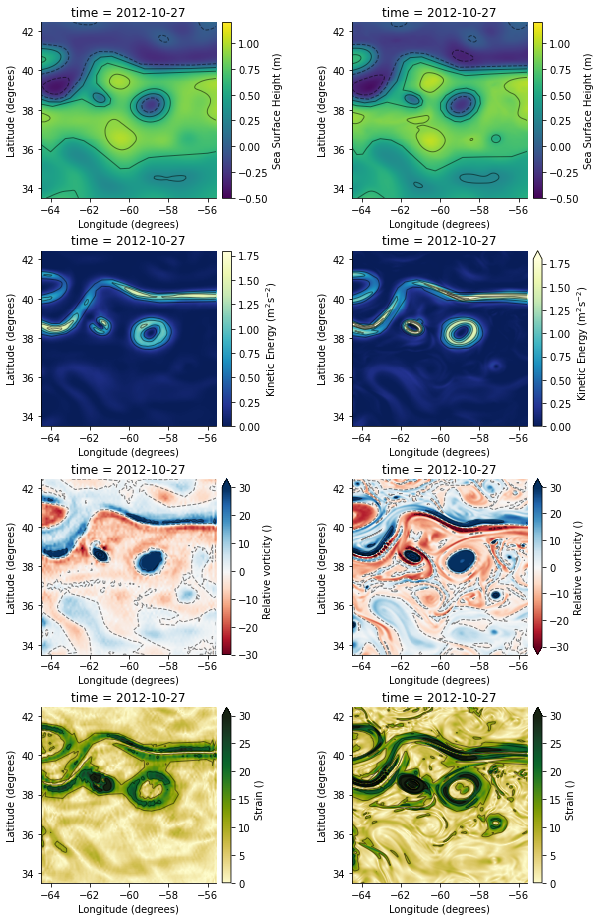

In [16]:
cfg.method='4dvarnet'
cfg.results.outputs.plots.maps.methods['4dvarnet'].inp = 'predictions.nc'
lb = hydra.utils.call(cfg.outputs)
plot_ds = lb.plots.build_ds.maps().isel(lat=slice(10, -10), lon=slice(10, -10))

import functools
import operator
import hvplot
import hvplot.xarray
hvplot.extension('matplotlib')
functools.reduce(operator.add, [p(plot_ds) for p in lb.plots.maps.values()]).opts(shared_axes=False, sublabel_format='').cols(2)